# Takens Embeddings

This notebook is adapted from the [course repo](https://github.com/trneedham/TDASpring21) by Dr. Tom Needham.

In this notebook, we'll explore the Takens embeddings introduced in lecture for applying TDA methods to time series data.

We'll use tge package `giotto-tda` which has a Takens embedding module with a lot of nice features.

In [1]:
# Import the gtda modules
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.pipeline import Pipeline

import numpy as np
from sklearn.metrics import pairwise_distances

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# gtda plotting functions
from gtda.plotting import plot_heatmap

# Import data from openml
import openml
from openml.datasets.functions import get_dataset

# Plotting functions
from gtda.plotting import plot_diagram, plot_betti_surfaces
from gtda.plotting import plot_point_cloud

# MatPLotLib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## A Simple Example

We'll start with a simple signal consisting of a noisy sine curve.

In [2]:
n_samples = 1000
domain = np.linspace(0,2*np.pi,n_samples)
noise_level = 0.5
frequency = 4

signal = np.array([np.sin(frequency*x) + noise_level * np.random.random() for x in domain])

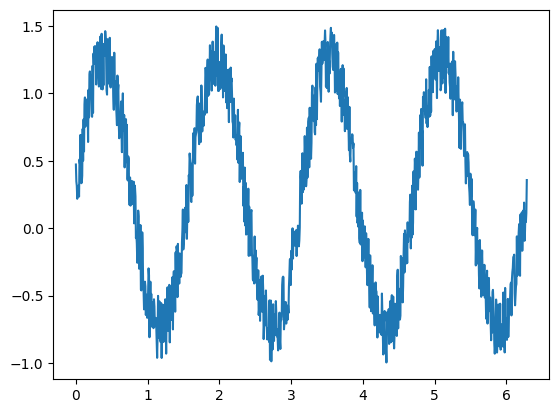

In [3]:
plt.plot(domain,signal)
plt.show()

The *sliding window embedding* of the signal $f:[0,2\pi] \to \mathbb{R}$ is defined in terms of two parameters:
- $\tau$ is the *delay*
- $d$ is the *embedding dimension*

The sliding window embedding is given by
\begin{align}
\mathrm{SW}_{d,\tau}f:[0,2\pi] &\to \mathbb{R}^d \\
t &\mapsto \mathrm{SW}_{d,\tau}f(t) = (f(t),f(t + \tau),f(t+2\tau),\ldots,f(t+(d-1)\tau))
\end{align}

What do we expect when $g$ is a perfect sine function?

Let $g:[0,2\pi]\to\R$ be the sine function $g(x)=\sin(wx)$. Then,
$$\begin{align*}
&\mathrm{SW}_{d,\tau}g(t) = (\sin(wt),\sin(w(t + \tau)),\sin(w(t+2\tau)),\ldots,\sin(w(t+(d-1)\tau)))\\
&=(\sin(wt),\sin(wt)\cos(w\tau) +\cos(wt)\sin(w\tau),\ldots,\sin(wt)\cos((d-1)w\tau) +\cos(wt)\sin((d-1)w\tau))\\
&=\sin(wt)(1,\cos(w\tau),\ldots,\cos((d-1)w\tau)) + \cos(wt)(0,\sin(w\tau),\ldots,\sin((d-1)w\tau))\\
&=\sin(wt)\mathbf{v} + \cos(wt)\mathbf{w}
\end{align*}$$

This is an ellipse in the plane spanned by $\mathbf{v}$ and $\mathbf{w}$. When $\mathbf{v}\cdot\mathbf{w}=0$ and $\|\mathbf{v}\|=\|\mathbf{w}\|$, then the embedding is a circle.

This happens when 
$$\begin{align*}
0&=\mathbf{v}\cdot\mathbf{w} = \cos(w\tau)\sin(w\tau) + \cos(2w\tau)\sin(2w\tau) + \cdots + \cos((d-1)w\tau)\sin((d-1)w\tau)\\
&=\frac{1}{2}\sum_{k=0}^{d-1}\sin(2kw\tau) \\
&= \frac{\sin(wd\tau)\sin(w(d-1)\tau)}{2\sin(w\tau)}
\end{align*}$$
and
$$\begin{align*}
0&=\|\mathbf{v}\|^2-\|\mathbf{w}\|^2\\
&=1+\cos^2(w\tau)+\cos^2(2w\tau)+\cdots\\
&-0^2-\sin^2(w\tau)-\cdots\\
&= \frac{\sin(wd\tau)\cos(w(d-1)\tau)}{\sin(w\tau)}
\end{align*}$$

Hence, $\frac{\sin(wd\tau)\cos(w(d-1)\tau)}{\sin(w\tau)}=\frac{\sin(wd\tau)\sin(w(d-1)\tau)}{\sin(w\tau)}=0$. This happens when $wd\tau = k\pi$ for some integer $k$. 


Let's start by embedding in $\mathbb{R}^3$ (i.e. $d = 3$). We can experiment with different delays.

In [5]:
dimension = 3
time_delay = 10

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

Let's take a look at the shape of the result.

In [6]:
print('Shape of embedded point cloud:', embedded_signal.shape)

Shape of embedded point cloud: (980, 3)


Notice that the number of points in the point cloud is `n_samples`-$(d-1)\tau$. This is to mitigate boundary effects on the sliding window.

Since we embedded in $\mathbb{R}^3$, we can take a look at the embedded point cloud.

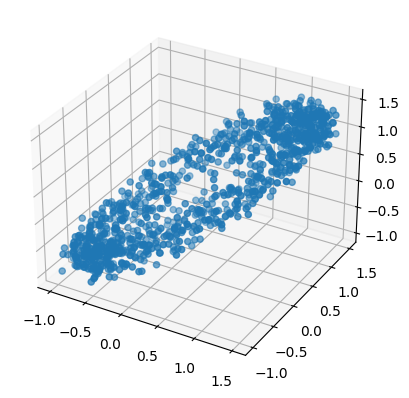

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = embedded_signal[:,0]
ys = embedded_signal[:,1]
zs = embedded_signal[:,2]

ax.scatter(xs, ys, zs)
plt.show()

It looks like a noisy ellipse, which agrees with our computation. `giotto` has some useful plotting tools which allow us to manipulate the plot to get a better view.

In [8]:
plot_point_cloud(embedded_signal)

We did a computation  which showed that the embedded point cloud is at its 'roundest' when $\omega \cdot d \cdot \tau = 0 \, (\mathrm{mod} \, \pi)$, where $\omega$ is the frequency. Since we are embedding with $d = 3$, we should get a round circle when $\tau = \frac{\pi}{3\omega}$. Let's test this out.

**Note:** Since we are working with a discrete approximation of the signal, $\tau$ is input as an integer---i.e., it's the number of indices to skip in the vector of signal sample values. This means we need to do a coordinate transformation and use the following time delay
$$
\hat{\tau} = \tau \cdot \frac{\mathrm{n}}{2\pi} = \frac{\pi}{3\omega} \cdot \frac{\mathrm{n}}{2\pi} = \frac{\mathrm{n}}{6 \omega},
$$
where $n = $`n_samples`.

In [9]:
time_delay = int(n_samples/(6*frequency))

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

plot_point_cloud(embedded_signal)

Trying this for different values of $\tau$, we see that the value above does seem to be of 'optimal roundness'.

In [10]:
tau = np.pi/50 # tau is a number between 0 and 2pi

time_delay = int(tau*n_samples/(2*np.pi)) # coordinate transformation to discrete steps

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

plot_point_cloud(embedded_signal)

Computing the PH of the embedded point cloud, we see that it has the (noisy) homology of a circle. The following is the syntax used for persistent homology in the `giotto` library.

In [15]:
homology_dimensions = [1]
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=100, homology_dimensions=homology_dimensions)

X_diagrams = VR.fit_transform(embedded_signal[None, :, :])

In [16]:
plot_diagram(X_diagrams[0])

As expected, the 'distinctness' of the degree-1 feature depends a lot on the parameters for the Takens embedding. We can see this by running over a few choices of $\tau$.

In [23]:
taus = [np.pi/(20*frequency),np.pi/(5*frequency),np.pi/(3*frequency),np.pi/(2*frequency)]


tau = taus[0]

time_delay = int(tau*n_samples/(2*np.pi))

embedder = SingleTakensEmbedding(parameters_type='fixed',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

X_diagrams = VR.fit_transform(embedded_signal[None, :, :])
plot_diagram(X_diagrams[0])


This should lead you to ask: given a signal with unknown 'ground truth' topology, how do we choose the correct $\tau$? Furthermore, how do we choose the correct embedding dimension $d$?

To my knowledge, this is still an open theoretical question in the TDA literature. The `giotto` package does have some statistical heuristics to choose 'optimal' parameters. To use this functionality, the user initializes with upper bounds on $d$ and $\tau$, and some existing algorithms are used to adjust them.

**Note:** The initial upper bounds must satisfy $n \geq (d-1)*\tau$, where $n$ is the number of samples and $\tau$ is the discrete time delay.

**Heuristic:** Since the initializations give upper bounds, choosing them high (but satisfying the inequality above) seems to work best. However, choosing high upper bounds also increases compute time, so there is a trade off here.

In [24]:
dimension = 30
time_delay = 30

embedder = SingleTakensEmbedding(parameters_type='search',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

print('Optimal embedding time delay based on mutual information:', embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',embedder.dimension_)
print('Shape of embedded point cloud:', embedded_signal.shape)

Optimal embedding time delay based on mutual information: 29
Optimal embedding dimension based on false nearest neighbors: 8
Shape of embedded point cloud: (797, 8)


In [25]:
homology_dimensions = [1]
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=100, homology_dimensions=homology_dimensions)

X_diagrams = VR.fit_transform(embedded_signal[None, :, :])
plot_diagram(X_diagrams[0])

Let's compare the learned parameters to the optimal ones. We first convert the discrete time delay to the continuous one:

In [26]:
d = embedder.dimension_
tau = embedder.time_delay_

tau_continuous = tau*np.pi/n_samples

We then compute the quantity $\omega \cdot \tau \cdot d$ and divide by $\pi$. If the parameters are optimal, then the result should be an integer.

In [27]:
frequency*tau_continuous*d/np.pi

0.928